# SIFT and SVM

SVM model with SIFT descriptors used in the training of the model.

Run these code blocks in order, with the main function being at the last one.  The code blocks before are function definitions.

# Images Related Functions

Functions for displaying images, and images with keypoints.  There is a function for saving images to disk as png files but it is not used in the code below.

In [11]:
# images related functions code
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import random

def display_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')  # Hide axis
    plt.show()

def save_image_plot(image, filename, save_dir='plot_outputs'):
    os.makedirs(save_dir, exist_ok=True)
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(filename)
    plt.axis('off')
    save_path = os.path.join(save_dir, f'{filename}.png')
    plt.savefig(save_path)
    plt.close()

def display_image_with_keypoints(image, keypoints, title="Image with Keypoints"):
    # Ensure the image is in the correct range
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img_with_keypoints = cv2.drawKeypoints(image_uint8, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def display_keypoints(images, keypoints_list, num_images=5):
    valid_indices = [i for i, keypoints in enumerate(keypoints_list) if keypoints]
    if len(valid_indices) < num_images:
        num_images = len(valid_indices)
    selected_indices = random.sample(valid_indices, num_images)
    for i in selected_indices:
        display_image_with_keypoints(images[i], keypoints_list[i], title=f"Image {i + 1} with Keypoints")


# Label Loading

In [2]:
# label related code
import scipy.io
import numpy as np

def load_labels(mat_file, num_labels=63445):
    print("Loading labels...")
    labels = scipy.io.loadmat(mat_file)['labels'].flatten()[:num_labels]
    print(f"Loaded {len(labels)} labels.\n")
    return labels

def print_label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)
    print("Label Distribution:")
    for label, count in zip(unique, counts):
        percentage = (count / total) * 100
        print(f"Label {label}: {count} ({percentage:.2f}%)")


# Preprocessing

Some main concepts of the preprocessing are of image sizes 64 x 64, normalized pixel values of between 0-1, and Grayscale.

In [3]:
# preprocessing code
import cv2
import numpy as np
import os

def preprocess_images(image_dir, num_images):
    print("Preprocessing images...")
    images = []
    for i in range(1, num_images + 1):
        img_path = os.path.join(image_dir, f"{i}.png")
        if not os.path.exists(img_path):
            print(f"Warning: Image {img_path} not found")
            continue

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (64, 64))
        image = image / 255.0
        images.append(image)

        if i % 5000 == 0:
            print(f"Processed images {i-4999}-{i}")
    
    print("Finished preprocessing images.\n")
    return np.array(images)


# SIFT Extraction

SIFT extraction code for extracting keypoints and descriptors.  This is covered more later also.  Descriptors are used in the SVM model, with the descriptors being based on the keypoints. We will go over some statistics on keypoints though later, including keypoints overlayed on images for visualization purposes.

In [4]:
# SIFT related code
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sift_svm_local4_image_utils import display_image_with_keypoints

def extract_sift_features(images, max_features=500):
    print("Extracting SIFT features...")
    sift = cv2.SIFT_create()
    all_descriptors = []
    keypoints_list = []
    valid_images = 0
    
    for i, image in enumerate(images):
        image_uint8 = (image * 255).astype(np.uint8)
        keypoints, descriptors = sift.detectAndCompute(image_uint8, None)
        
        if keypoints and descriptors is not None:
            keypoints_list.append(keypoints)
            if descriptors.shape[0] < max_features:
                padded_descriptor = np.zeros((max_features, 128))
                padded_descriptor[:descriptors.shape[0], :] = descriptors
                all_descriptors.append(padded_descriptor)
            else:
                all_descriptors.append(descriptors[:max_features, :])
            valid_images += 1
        else:
            keypoints_list.append([])
            padded_descriptor = np.zeros((max_features, 128))
            all_descriptors.append(padded_descriptor)
        
        if (i + 1) % 10000 == 0:
            print(f"Processed SIFT features for {i + 1}/{len(images)} images")

    print(f"SIFT feature extraction completed. Valid images with features: {valid_images}/{len(images)}\n")
    return all_descriptors, keypoints_list

def get_keypoint_statistics(keypoints_list):
    num_keypoints = [len(kp) for kp in keypoints_list if len(kp) > 0]
    avg_keypoints = np.mean(num_keypoints)
    max_keypoints = np.max(num_keypoints)
    min_keypoints = np.min(num_keypoints)
    return avg_keypoints, max_keypoints, min_keypoints

def display_keypoints(images, keypoints_list, num_images=5):
    for i in range(min(num_images, len(images))):
        display_image_with_keypoints(images[i], keypoints_list[i], title=f"Image {i + 1} with Keypoints")


# Dataset Splitting, Model Building, Training, Validation, and Testing Code

In [5]:
# dataset splitting, model building, training, validation and testing code
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

def print_label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)
    print("Label Distribution:")
    for label, count in zip(unique, counts):
        percentage = (count / total) * 100
        print(f"Label {label}: {count} ({percentage:.2f}%)")

def train_and_evaluate(X, y, sample_size=10000):
    print("Starting training and evaluation...")

    # Convert to float32 to save memory
    X = X.astype(np.float32)

    # Sample 10,000 images directly from the original dataset
    X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=sample_size, random_state=42)
    print(f"Sampled data shape: {X_sampled.shape}")

    # Print label distribution of the sampled data
    print("Label distribution in sampled data:")
    print_label_distribution(y_sampled)

    # Split the sampled data into new training, validation, and testing datasets
    X_train, X_temp, y_train, y_temp = train_test_split(X_sampled, y_sampled, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print(f"Sampled data split: {len(X_train)} training, {len(X_val)} validation, {len(X_test)} testing samples")

    # Print label distribution of the training, validation, and testing datasets
    print("Label distribution in training data:")
    print_label_distribution(y_train)
    print("Label distribution in validation data:")
    print_label_distribution(y_val)
    print("Label distribution in testing data:")
    print_label_distribution(y_test)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    print("Data standardized")

    # Build and train the SVM model
    svm_model = SVC(kernel='linear')
    print("Training SVM model...")
    svm_model.fit(X_train, y_train)
    print("SVM model trained")

    # Validate the model
    print("Validating model...")
    y_val_pred = svm_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Test the model
    print("Testing model...")
    y_test_pred = svm_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy}")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))


# Function for Displaying Random Images

A function for displaying random images.  We will use this to display a basic image, along with ones with keypoints.  You can change the num_images to any number of images you want.  It is set to 2 currently.

In [ ]:
def display_random_images(images, num_images=2):
    random_indices = random.sample(range(len(images)), num_images)
    for i in random_indices:
        display_image(images[i], title=f"Random Image {i + 1}")

# Function Calling

Below we will call the various functions we have defined above.

## Labels and Image Preprocessing

Below we will set some variables related to loading the labels, and then call the preprocess_images function to preprocess the images.  This function will create our feature matrix from the dataset.  We will then later split this feature matrix.

In [14]:
# Local directory paths
image_dir = 'cells'  # Directory containing images
mat_file = 'labels.mat'  # Labels file
num_images = 63445

# Load labels and preprocess images
labels = load_labels(mat_file, num_labels=num_images)
print_label_distribution(labels)
images = preprocess_images(image_dir, num_images)

Loading labels...
Loaded 63445 labels.

Label Distribution:
Label 1: 14367 (22.64%)
Label 2: 14655 (23.10%)
Label 3: 13257 (20.90%)
Label 4: 13737 (21.65%)
Label 5: 5086 (8.02%)
Label 6: 2343 (3.69%)
Preprocessing images...
Processed images 1-5000
Processed images 5001-10000
Processed images 10001-15000
Processed images 15001-20000
Processed images 20001-25000
Processed images 25001-30000
Processed images 30001-35000
Processed images 35001-40000
Processed images 40001-45000
Processed images 45001-50000
Processed images 50001-55000
Processed images 55001-60000
Finished preprocessing images.



We see our label distribution above.  Classes 1 to 4 have similar numbers, about 20 percent each.  Classes 5 and 6 have much less, with them being about 8 percent and about 4 percent.

## Display a Few Images

We will display a few images to show the kind of dataset we are working with.  Later we will show a few with keypoints overlayed. 

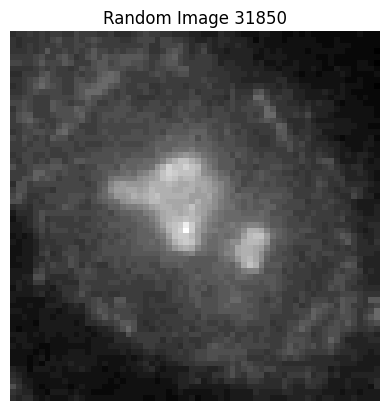

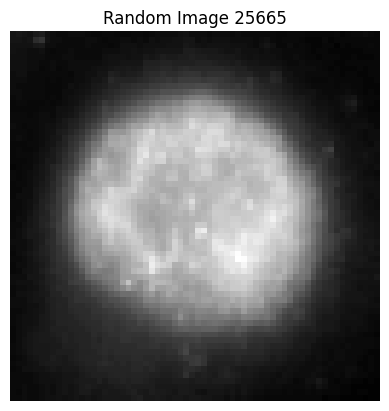

In [16]:
# Display 2 random images from the dataset
display_random_images(images, num_images=2)

These two randomly displayed images are just for information purposes to show the dataset images.  Below we will randomly select two more to display the keypoints on them.

## SIFT Feature Extraction

In [17]:
# Extract SIFT features
image_features, keypoints_list = extract_sift_features(images)

Extracting SIFT features...
Processed SIFT features for 10000/63445 images
Processed SIFT features for 20000/63445 images
Processed SIFT features for 30000/63445 images
Processed SIFT features for 40000/63445 images
Processed SIFT features for 50000/63445 images
Processed SIFT features for 60000/63445 images
SIFT feature extraction completed. Valid images with features: 30115/63445



Almost half of our 63,000 images have extracted SIFT features.

Keypoints are specific points in an image that are considered to be interesting or distinctive. These points are typically corners, edges, or blobs that are invariant to scale and rotation. In the context of SIFT (Scale-Invariant Feature Transform), keypoints are detected using a difference of Gaussian approach, and each keypoint has attributes such as:

Location (x, y coordinates)
Scale (size of the keypoint)
Orientation (direction of the keypoint)

When we display keypoints on an image, we are visualizing these distinctive points, often with circles or arrows indicating their scale and orientation.

Descriptors are vectors that describe the local appearance around each keypoint. In SIFT, a descriptor is a 128-dimensional vector that captures the gradient information around the keypoint in a way that is invariant to scale, rotation, and illumination changes. These descriptors are used to match keypoints between different images.

## Example Keypoint and Descriptor

In [18]:
# Print one example keypoint and one example descriptor
for i, keypoints in enumerate(keypoints_list):
    if keypoints:
        print(f"Example keypoint from image {i + 1}: {keypoints[0]}")
        print(f"Example descriptor from image {i + 1}: {image_features[i][0]}")
        break

Example keypoint from image 79: < cv2.KeyPoint 0x172ded2f0>
Example descriptor from image 79: [  3.   0.   0.   0.   0.   0.   0.  11.  22.   0.   0.   0.   0.   0.
  19. 106.  73.   0.   0.   0.   0.   2.  34. 104.  52.   1.   0.   0.
   2.  17.  16.  32.  65.   1.   0.   0.   0.   0.   0.  47. 133.  18.
   3.   3.   2.  10.  93. 133.  21.   5.   5.  31.  52. 114. 133.  79.
  51.  32.   4.   8.  13.  17.   7.   6.  76.  15.   0.   0.   0.   0.
   0.   9. 133. 133.  95.  22.   2.   3.   6.  39.  12.  39. 133. 133.
  56.  26.   9.   9.   4.  89.  51.  40.  11.   2.   0.   0.   3.   2.
   0.   0.   0.   0.   0.   0.   7.  43.  49.   6.   0.   0.   0.   0.
   0.   9. 111.  43.   0.   0.   0.   0.   0.  42.  73.   4.   0.   0.
   0.   0.]


Above is an example keypoint and descriptor, to show what they technically look like.

## Keypoint Stats

In [19]:
# Get keypoint statistics
avg_keypoints, max_keypoints, min_keypoints = get_keypoint_statistics(keypoints_list)
print(f"Average number of keypoints: {avg_keypoints}")
print(f"Maximum number of keypoints: {max_keypoints}")
print(f"Minimum number of keypoints: {min_keypoints}")

Average number of keypoints: 7.649211356466877
Maximum number of keypoints: 59
Minimum number of keypoints: 1


Of our 30,000 SIFT feature images, the average number of keypoints per image is about 8.  The highest keypoint image has 59 keypoints, and the lowest is 1.

## Keypoint Overlay Display

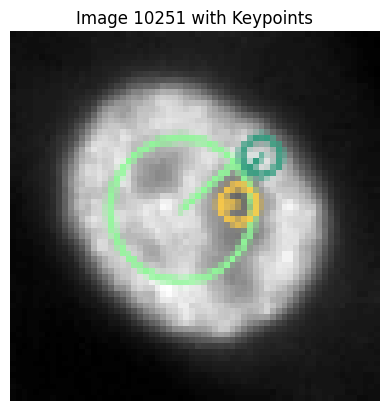

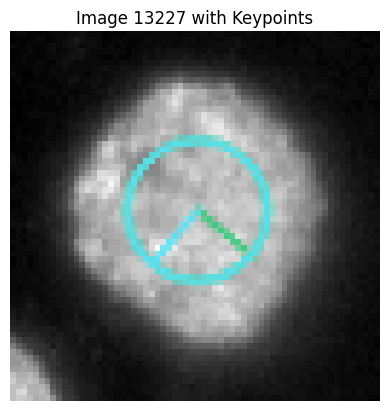

In [57]:
# Display keypoints on a few images
display_keypoints(images, keypoints_list, num_images=2)

This is randomly selected two images.  Some of the images don't have keypoints.  If you run the code block above it will randomly select two, and if you don't get one or two with keypoints keep running the code block.  You will be able to get two to show up like above.

As a side note on our SVM model with SIFT, it uses descriptors, not keypoints.  Descriptors are based on keypoints.

## Flatten the Descriptors

This is a process of converting the data type to a 1 dimensional array.

In [ ]:
# Flatten the list of descriptors
X = np.array([desc.flatten() for desc in image_features])
y = np.array(labels)

## Split, Train, Validate, and Test the Model

In [ ]:
# Train and evaluate the model
train_and_evaluate(X, y)

Starting training and evaluation...
Sampled data shape: (10000, 64000)
Label distribution in sampled data:
Label Distribution:
Label 1: 2286 (22.86%)
Label 2: 2371 (23.71%)
Label 3: 2046 (20.46%)
Label 4: 2106 (21.06%)
Label 5: 827 (8.27%)
Label 6: 364 (3.64%)
Sampled data split: 6000 training, 2000 validation, 2000 testing samples
Label distribution in training data:
Label Distribution:
Label 1: 1381 (23.02%)
Label 2: 1422 (23.70%)
Label 3: 1240 (20.67%)
Label 4: 1248 (20.80%)
Label 5: 491 (8.18%)
Label 6: 218 (3.63%)
Label distribution in validation data:
Label Distribution:
Label 1: 454 (22.70%)
Label 2: 493 (24.65%)
Label 3: 405 (20.25%)
Label 4: 422 (21.10%)
Label 5: 151 (7.55%)
Label 6: 75 (3.75%)
Label distribution in testing data:
Label Distribution:
Label 1: 451 (22.55%)
Label 2: 456 (22.80%)
Label 3: 401 (20.05%)
Label 4: 436 (21.80%)
Label 5: 185 (9.25%)
Label 6: 71 (3.55%)
Data standardized
Training SVM model...
SVM model trained
Validating model...
Validation Accuracy: 0.3

: 

We have about a .39 percent accuracy for both validation and testing.  The model we are using is not dropping images that don't have SIFT features.  We will try a model that does in another notebook, which gives a .70 percent accuracy. 